# ai4 for health related matters

## dependencies

In [114]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## dataset stuff

### read the dataset

In [115]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac = 1)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
90,66,1,4,120,302,0,2,151,0,0.4,2,0.0,3.0,0
111,56,1,4,125,249,1,2,144,1,1.2,2,1.0,3.0,1
216,46,0,2,105,204,0,0,172,0,0.0,1,0.0,3.0,0
33,59,1,4,135,234,0,0,161,0,0.5,2,0.0,7.0,0
80,45,1,4,104,208,0,2,148,1,3.0,2,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,40,1,1,140,199,0,0,178,1,1.4,1,0.0,7.0,0
191,51,1,4,140,298,0,0,122,1,4.2,2,3.0,7.0,3
264,61,1,4,138,166,0,2,125,1,3.6,2,1.0,3.0,4
54,60,1,4,130,253,0,0,144,1,1.4,1,1.0,7.0,1


### train_test split

In [139]:
ratio = 0.95 # 90:10 train:test ratio
train_set = df.sample(frac=ratio)

# Dropping all those indexes from the dataframe that exists in the train_set
test_set = df.drop(train_set.index)
train_set.shape, test_set.shape

train_set
test_set

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
45,58,1,3,112,230,0,2,165,0,2.5,2,1.0,7.0,4
200,50,0,4,110,254,0,2,159,0,0.0,1,0.0,3.0,0
107,57,1,3,128,229,0,2,150,0,0.4,2,1.0,7.0,1
24,60,1,4,130,206,0,2,132,1,2.4,2,2.0,7.0,4
113,43,0,4,132,341,1,2,136,1,3.0,2,0.0,7.0,2
171,53,1,4,142,226,0,2,111,1,0.0,1,0.0,7.0,0
53,44,1,2,130,219,0,2,188,0,0.0,1,0.0,3.0,0
239,42,1,2,120,295,0,0,162,0,0.0,1,0.0,3.0,0
297,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1
134,43,0,3,122,213,0,0,165,0,0.2,2,0.0,3.0,0


### formating

In [140]:
# import training dataset

# Clean column names
train_set.columns = train_set.columns.str.strip()

# Handle missing values represented by '?'
train_set = train_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
train_set = train_set.dropna()
train_set = train_set.astype(float)

# Split features and labels
X = train_set.drop("diagnosis", axis=1)
y = train_set["diagnosis"]

y = (y > 0.5).astype(float)  # Ensures only 0 or 1

# normalise featuress from minmax scaling (sklearn)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
inputs = torch.tensor(X_scaled, dtype=torch.float32)
targets = torch.tensor(y.values, dtype=torch.float32)

print(inputs.shape, targets.shape)

torch.Size([282, 13]) torch.Size([282])


In [141]:
# import training dataset

# Clean column names
test_set.columns = test_set.columns.str.strip()

# Handle missing values represented by '?'
test_set = test_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
test_set = test_set.dropna()
test_set = test_set.astype(float)

# Split features and labels
X = test_set.drop("diagnosis", axis=1)
y = test_set["diagnosis"]

y = (y > 0.5).astype(float)  # Ensures only 0 or 1

# normalise featuress from minmax scaling (sklearn)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
test_inputs = torch.tensor(X_scaled, dtype=torch.float32)
test_targets = torch.tensor(y.values, dtype=torch.float32)

print(test_inputs.shape, test_targets.shape)

torch.Size([15, 13]) torch.Size([15])


## AI1

### setup/params

In [142]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26, 1)
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=26, out_features=1, bias=True)
)


### error calcs.

In [143]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
      

### training

In [144]:
# learning rate and epochs
epochs = 10000
lr = 0.005

Epoch [1/10000], Loss: 0.7158
Epoch [2/10000], Loss: 0.7155
Epoch [3/10000], Loss: 0.7153
Epoch [4/10000], Loss: 0.7150
Epoch [5/10000], Loss: 0.7148
Epoch [6/10000], Loss: 0.7146
Epoch [7/10000], Loss: 0.7143
Epoch [8/10000], Loss: 0.7141
Epoch [9/10000], Loss: 0.7139
Epoch [10/10000], Loss: 0.7136
Epoch [11/10000], Loss: 0.7134
Epoch [12/10000], Loss: 0.7132
Epoch [13/10000], Loss: 0.7130
Epoch [14/10000], Loss: 0.7127
Epoch [15/10000], Loss: 0.7125
Epoch [16/10000], Loss: 0.7123
Epoch [17/10000], Loss: 0.7121
Epoch [18/10000], Loss: 0.7118
Epoch [19/10000], Loss: 0.7116
Epoch [20/10000], Loss: 0.7114
Epoch [21/10000], Loss: 0.7112
Epoch [22/10000], Loss: 0.7110
Epoch [23/10000], Loss: 0.7107
Epoch [24/10000], Loss: 0.7105
Epoch [25/10000], Loss: 0.7103
Epoch [26/10000], Loss: 0.7101
Epoch [27/10000], Loss: 0.7099
Epoch [28/10000], Loss: 0.7097
Epoch [29/10000], Loss: 0.7095
Epoch [30/10000], Loss: 0.7092
Epoch [31/10000], Loss: 0.7090
Epoch [32/10000], Loss: 0.7088
Epoch [33/10000],

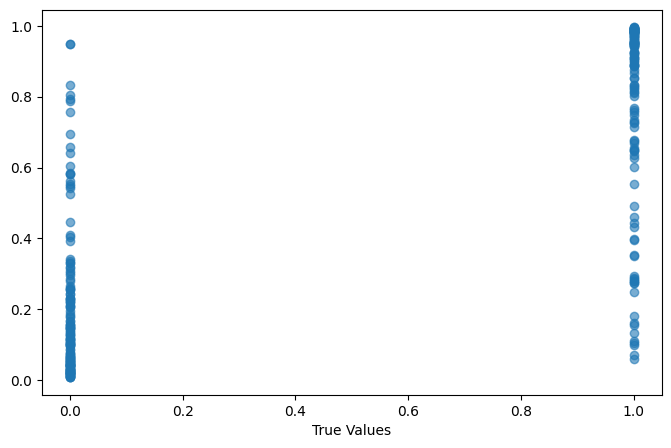

In [145]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy1 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy1.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

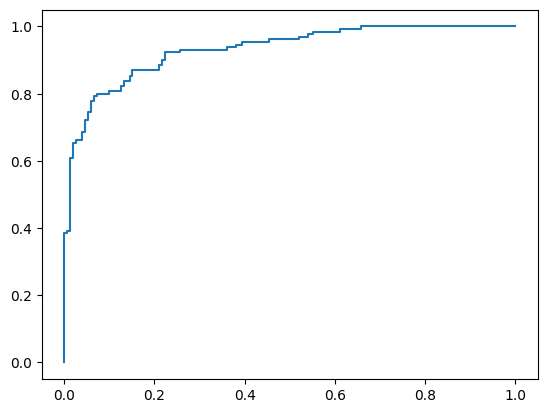

In [146]:
# roc curve
fpr1, tpr1, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr1, tpr1, label = "ROC Curve")

tensor(0.4667)
Training Accuracy: 50.22%


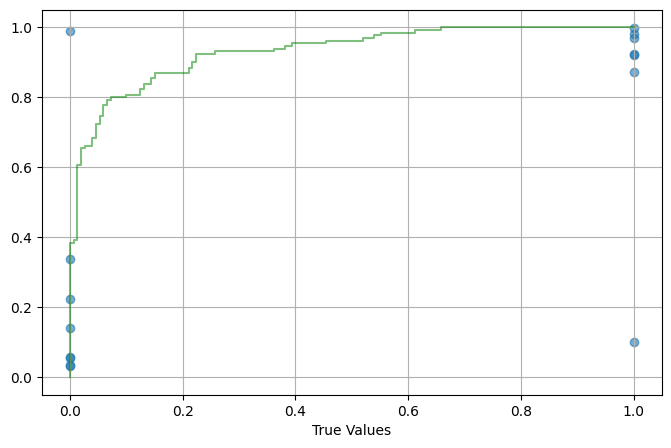

In [147]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs1 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs1)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy1 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy1.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

# roc curve
test_fpr1, test_tpr1, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(test_fpr1, test_tpr1, label = "ROC Curve", color = "green", alpha=0.5)
plt.grid(True)

## AI2

### setup/params.

In [148]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.celu = nn.CELU()
        self.fc2 = nn.Linear(26, 32)
        self.rrelu2 = nn.RReLU()
        self.fc3 = nn.Linear(32, 100)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(100, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 1) #output layer
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.celu(x)
        x = self.fc2(x)
        x = self.rrelu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
model

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (celu): CELU(alpha=1.0)
  (fc2): Linear(in_features=26, out_features=32, bias=True)
  (rrelu2): RReLU(lower=0.125, upper=0.3333333333333333)
  (fc3): Linear(in_features=32, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=64, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

### error calcs.

In [149]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
      

### training

In [150]:
# learning rate and epochs (variables)
epochs = 30000
lr = 0.05

Epoch [1/30000], Loss: 0.6917
Epoch [2/30000], Loss: 0.6917
Epoch [3/30000], Loss: 0.6917
Epoch [4/30000], Loss: 0.6916
Epoch [5/30000], Loss: 0.6916
Epoch [6/30000], Loss: 0.6915
Epoch [7/30000], Loss: 0.6915
Epoch [8/30000], Loss: 0.6915
Epoch [9/30000], Loss: 0.6915


Epoch [10/30000], Loss: 0.6914
Epoch [11/30000], Loss: 0.6914
Epoch [12/30000], Loss: 0.6913
Epoch [13/30000], Loss: 0.6912
Epoch [14/30000], Loss: 0.6913
Epoch [15/30000], Loss: 0.6912
Epoch [16/30000], Loss: 0.6912
Epoch [17/30000], Loss: 0.6911
Epoch [18/30000], Loss: 0.6910
Epoch [19/30000], Loss: 0.6910
Epoch [20/30000], Loss: 0.6910
Epoch [21/30000], Loss: 0.6909
Epoch [22/30000], Loss: 0.6909
Epoch [23/30000], Loss: 0.6908
Epoch [24/30000], Loss: 0.6908
Epoch [25/30000], Loss: 0.6908
Epoch [26/30000], Loss: 0.6908
Epoch [27/30000], Loss: 0.6908
Epoch [28/30000], Loss: 0.6907
Epoch [29/30000], Loss: 0.6907
Epoch [30/30000], Loss: 0.6906
Epoch [31/30000], Loss: 0.6906
Epoch [32/30000], Loss: 0.6905
Epoch [33/30000], Loss: 0.6906
Epoch [34/30000], Loss: 0.6905
Epoch [35/30000], Loss: 0.6904
Epoch [36/30000], Loss: 0.6904
Epoch [37/30000], Loss: 0.6904
Epoch [38/30000], Loss: 0.6904
Epoch [39/30000], Loss: 0.6903
Epoch [40/30000], Loss: 0.6902
Epoch [41/30000], Loss: 0.6902
Epoch [4

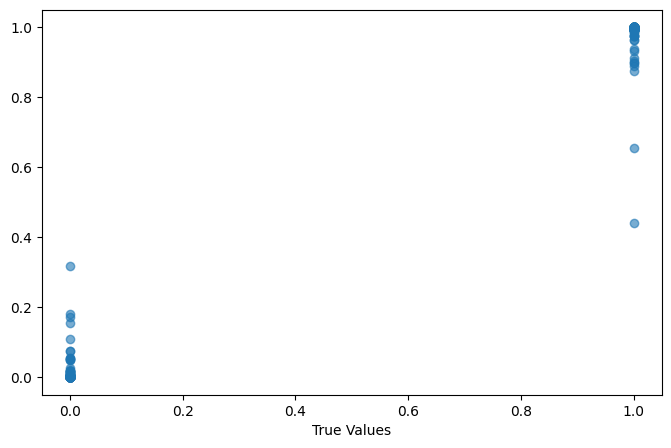

In [151]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy2 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy2.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

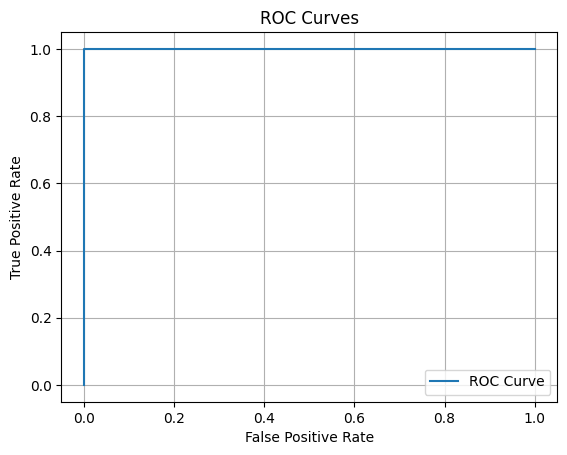

In [152]:
# roc curve
fpr2, tpr2, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr2, tpr2, label = "ROC Curve")
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

tensor(0.4000)
Training Accuracy: 50.67%


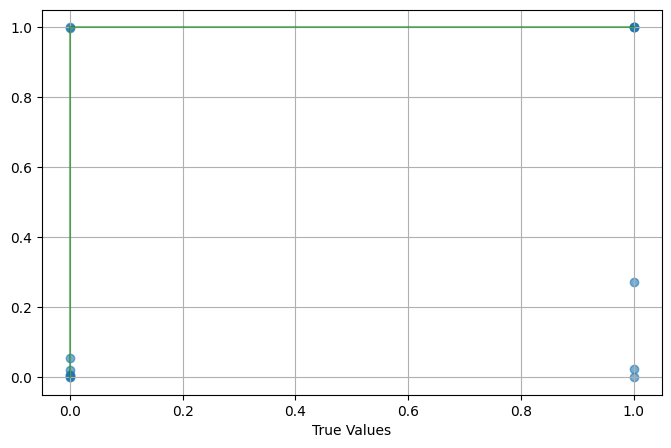

In [153]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs2 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs2)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy2 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy2.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

# roc curve
test_fpr2, test_tpr2, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(test_fpr2, test_tpr2, label = "ROC Curve", color = "green", alpha=0.5)
plt.grid(True)

## AI3

### setup/params

In [154]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.rrelu = nn.RReLU()
        self.fc2 = nn.Linear(26, 26)
        self.silu2 = nn.SiLU()
        self.fc3 = nn.Linear(26, 1)


    def forward(self, x): 
        x = self.fc1(x)
        x = self.rrelu(x)
        x = self.fc2(x)
        x = self.silu2(x)
        x = self.fc3(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (rrelu): RReLU(lower=0.125, upper=0.3333333333333333)
  (fc2): Linear(in_features=26, out_features=26, bias=True)
  (silu2): SiLU()
  (fc3): Linear(in_features=26, out_features=1, bias=True)
)


### error calcs.

In [155]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
      

### training

In [156]:
# learning rate and epochs
epochs = 10000
lr = 0.005

Epoch [1/10000], Loss: 0.6926
Epoch [2/10000], Loss: 0.6925
Epoch [3/10000], Loss: 0.6925
Epoch [4/10000], Loss: 0.6924
Epoch [5/10000], Loss: 0.6923
Epoch [6/10000], Loss: 0.6923
Epoch [7/10000], Loss: 0.6922
Epoch [8/10000], Loss: 0.6922
Epoch [9/10000], Loss: 0.6922
Epoch [10/10000], Loss: 0.6922
Epoch [11/10000], Loss: 0.6921
Epoch [12/10000], Loss: 0.6921
Epoch [13/10000], Loss: 0.6920
Epoch [14/10000], Loss: 0.6920
Epoch [15/10000], Loss: 0.6920
Epoch [16/10000], Loss: 0.6919
Epoch [17/10000], Loss: 0.6919
Epoch [18/10000], Loss: 0.6919
Epoch [19/10000], Loss: 0.6918
Epoch [20/10000], Loss: 0.6917
Epoch [21/10000], Loss: 0.6918
Epoch [22/10000], Loss: 0.6916
Epoch [23/10000], Loss: 0.6916
Epoch [24/10000], Loss: 0.6916
Epoch [25/10000], Loss: 0.6916
Epoch [26/10000], Loss: 0.6916
Epoch [27/10000], Loss: 0.6915
Epoch [28/10000], Loss: 0.6915
Epoch [29/10000], Loss: 0.6914
Epoch [30/10000], Loss: 0.6914
Epoch [31/10000], Loss: 0.6914
Epoch [32/10000], Loss: 0.6913
Epoch [33/10000],

Epoch [48/10000], Loss: 0.6907
Epoch [49/10000], Loss: 0.6907
Epoch [50/10000], Loss: 0.6906
Epoch [51/10000], Loss: 0.6906
Epoch [52/10000], Loss: 0.6906
Epoch [53/10000], Loss: 0.6905
Epoch [54/10000], Loss: 0.6904
Epoch [55/10000], Loss: 0.6905
Epoch [56/10000], Loss: 0.6904
Epoch [57/10000], Loss: 0.6903
Epoch [58/10000], Loss: 0.6904
Epoch [59/10000], Loss: 0.6904
Epoch [60/10000], Loss: 0.6902
Epoch [61/10000], Loss: 0.6902
Epoch [62/10000], Loss: 0.6902
Epoch [63/10000], Loss: 0.6901
Epoch [64/10000], Loss: 0.6902
Epoch [65/10000], Loss: 0.6900
Epoch [66/10000], Loss: 0.6901
Epoch [67/10000], Loss: 0.6901
Epoch [68/10000], Loss: 0.6900
Epoch [69/10000], Loss: 0.6899
Epoch [70/10000], Loss: 0.6899
Epoch [71/10000], Loss: 0.6899
Epoch [72/10000], Loss: 0.6899
Epoch [73/10000], Loss: 0.6898
Epoch [74/10000], Loss: 0.6898
Epoch [75/10000], Loss: 0.6897
Epoch [76/10000], Loss: 0.6897
Epoch [77/10000], Loss: 0.6897
Epoch [78/10000], Loss: 0.6896
Epoch [79/10000], Loss: 0.6896
Epoch [8

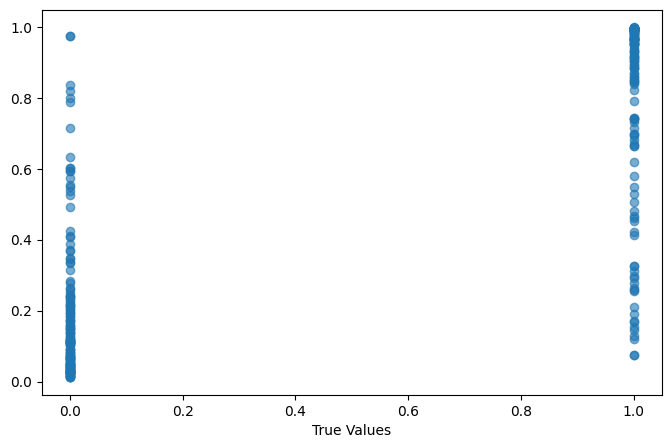

In [157]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy3 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy3.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

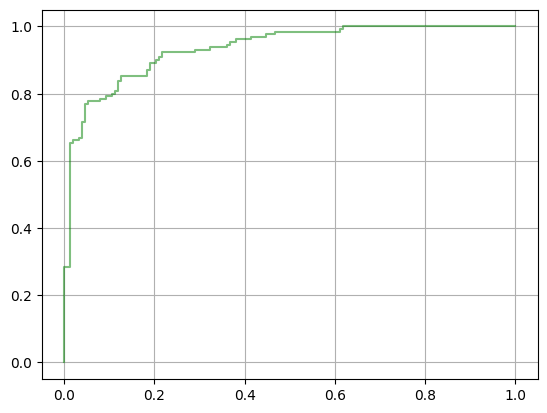

In [158]:
# roc curve
fpr3, tpr3, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr3, tpr3, label = "ROC Curve", color = "green", alpha=0.5)
plt.grid(True)

tensor(0.4667)
Training Accuracy: 50.22%


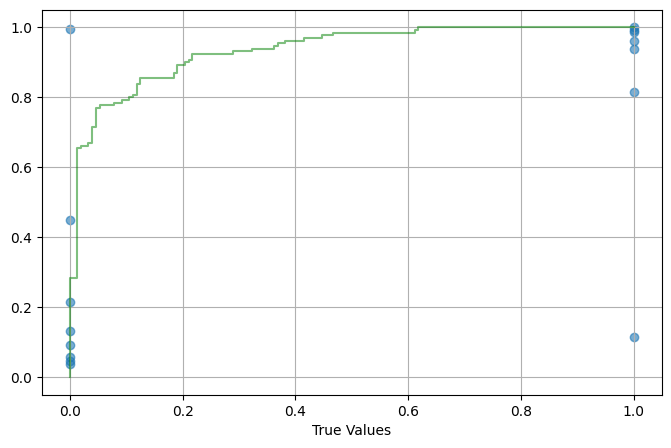

In [159]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs3 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs3)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy3 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy3.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

# roc curve
test_fpr3, test_tpr3, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(test_fpr3, test_tpr3, label = "ROC Curve", color = "green", alpha=0.5)
plt.grid(True)

## comparison

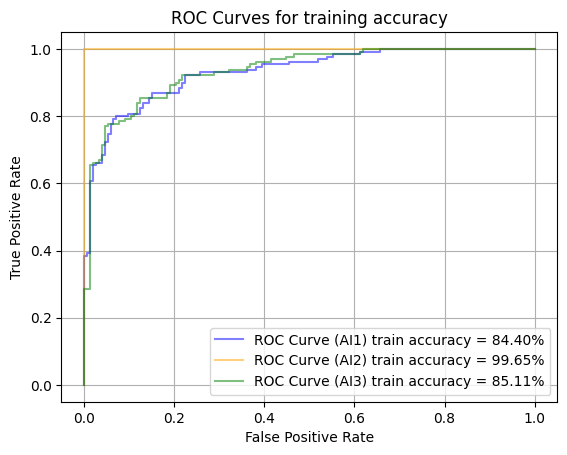

In [160]:
# roc curve
plt.plot(fpr1, tpr1, label = f"ROC Curve (AI1) train accuracy = {accuracy1.item()*100:.2f}%", c="blue", alpha=0.5) #blue
plt.plot(fpr2, tpr2, label = f"ROC Curve (AI2) train accuracy = {accuracy2.item()*100:.2f}%", c="orange", alpha=0.5) #orange
plt.plot(fpr3, tpr3, label = f"ROC Curve (AI3) train accuracy = {accuracy3.item()*100:.2f}%", c="green", alpha=0.5) #green
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for training accuracy")
plt.legend()

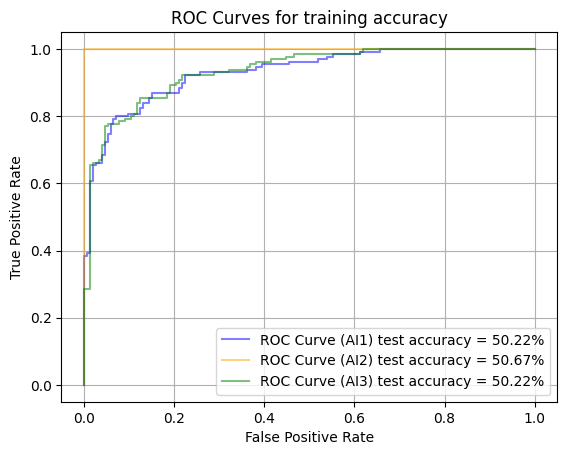

In [161]:
# roc curve
plt.plot(test_fpr1, test_tpr1, label = f"ROC Curve (AI1) test accuracy = {test_accuracy1.item()*100:.2f}%", c="blue", alpha=0.5) #blue
plt.plot(test_fpr2, test_tpr2, label = f"ROC Curve (AI2) test accuracy = {test_accuracy2.item()*100:.2f}%", c="orange", alpha=0.5) #orange
plt.plot(test_fpr3, test_tpr3, label = f"ROC Curve (AI3) test accuracy = {test_accuracy3.item()*100:.2f}%", c="green", alpha=0.5) #green
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for training accuracy")
plt.legend()